# Project 2: Credit Risk and Statistical Learning

**Names of all group members:**
- Rafael Barroso (rafael.barroso@epfl.ch)
- Philipp Mayer (philipp.mayer@epfl.ch)

In [46]:
## IMPORT NECESARY LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc


## 1: **Feature generation**

In [17]:
def gen_features(m: int, n: int, random_seed: int = 0) -> pd.DataFrame:
    """
    Generate (m + n) feature vectors for loan applicants.

    Each applicant i has:
        x_i1: age                  ~ Uniform[18, 80]
        x_i2: monthly income (CHF) ~ Uniform[1, 15]
        x_i3: employment status    ~ Bernoulli(p = 0.1); so we label as
                                    1 = self-employed
                                    0 = salaried

    All three coordinates are assumed independent.

    Parameters
    ----------
    m : int
        Number of training samples.
    n : int
        Number of test samples.
    random_seed : int or None, optional

    Returns
    -------
    features_df : pandas.DataFrame
        DataFrame with (m + n) rows and 3 columns:
            - "age"
            - "income"
            - "employment"
    """

    total_samples = m + n
    rng = np.random.default_rng(seed=random_seed) # Use numpy's random generator

    ## Simulate features
    ages = rng.integers(18, 80, size=total_samples)
    incomes = rng.uniform(low=1.0, high=15.0, size=total_samples)
    employment_status = rng.binomial(1, 0.1, size=total_samples)

    # Create DataFrame
    features_df = pd.DataFrame({
        "age": ages,
        "income": incomes,
        "employment": employment_status
    })

    return features_df

def compute_empirical_stats(features: pd.DataFrame, m: int) -> tuple[pd.Series, pd.Series]:
    """
    Compute empirical mean and variance of each feature using the training set.

    Parameters
    ----------
    features : pandas.DataFrame
        DataFrame containing features for all applicants.
    m : int
        Number of training samples.

    Returns
    -------
    means : pandas.Series
        Empirical means of each feature.
    variances : pandas.Series
        Empirical variances of each feature.
    """

    training_features = features.iloc[:m]

    means = training_features.mean()
    stds = training_features.std()

    return means, stds

In [5]:
m, n = 20000, 10000
features = gen_features(m, n, random_seed=0)
means, stds = compute_empirical_stats(features, m)
print(features.head())
print("Empirical Means:\n", means)
print("Empirical Standard Deviations:\n", stds)

   age     income  employment
0   70   3.720890           0
1   57   4.510488           0
2   49  12.752416           0
3   34  10.367952           0
4   37   3.414806           0
Empirical Means:
 age           48.454700
income         7.997856
employment     0.101000
dtype: float64
Empirical Standard Deviations:
 age           17.946112
income         4.028121
employment     0.301336
dtype: float64


In [6]:
(features['employment'] == 0).sum()

np.int64(27002)

dayum that's a lot of unemployed people lol

Some other realistic variables that might be used for credit scoring are:
- Debt to income ratio
- Past defaults/delinquencies
- Savings ammount
- Existing credit history (Although for Switzerland this is not usefull)

## 2: **Default model and data generation**

In [19]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    """
    Standard logistic (sigmoid) function:
        sigma(z) = 1 / (1 + exp(-z))
    """
    return 1.0 / (1.0 + np.exp(-z))

def p1_probability(features: pd.DataFrame) -> np.ndarray:
    """
    Compute repayment probabilities p1(x) for each row in `features`.

    Model 1:
        p1(x) = sigmoid(13.3 - 0.33 * age + 3.5 * income - 3 * employment)

    Here:
        - age = features["age"]
        - income = features["income"]
        - employment = features["employment"] (0 or 1)

    Returns
    -------
    probs : np.ndarray
        Array of repayment probabilities p1(x_i) with shape (n_samples,).
    """
    age = features["age"].to_numpy()
    income = features["income"].to_numpy()
    emp = features["employment"].to_numpy()

    # Linear predictor for model 1
    z = 13.3 - 0.33 * age + 3.5 * income - 3.0 * emp

    # Apply sigmoid to obtain probabilities in (0,1)
    probs = sigmoid(z)
    return probs

def p2_probability(features: pd.DataFrame) -> np.ndarray:
    """
    Compute repayment probabilities p2(x) for each row in `features`.

    Model 2 (piecewise in age via indicator functions):

        Let:
            young = 1 if age <= 25, else 0
            old   = 1 if age >= 75, else 0

        Then:
            p2(x) = sigmoid( -5 - 10 * young - 10 * old + 1.1 * income - 1.0 * employment )

    Returns
    -------
    probs : np.ndarray
        Array of repayment probabilities p2(x_i) with shape (n_samples,).
    """
    age = features["age"].to_numpy()
    income = features["income"].to_numpy()
    emp = features["employment"].to_numpy()

    # Indicator variables for age
    # young = 1 if age in (18, 25], old = 1 if age in [75, 80]
    young = (age <= 25.0).astype(float)
    old = (age >= 75.0).astype(float)

    # Linear predictor for model 2
    z = -5.0 - 10.0 * young - 10.0 * old + 1.1 * income - 1.0 * emp

    probs = sigmoid(z)
    return probs

def generate_repayment_data(features: pd.DataFrame, random_seed: int = 0) -> pd.DataFrame:
    """
    Given a matrix of features X (as a DataFrame), generate repayment
    outcomes y^1 and y^2 for both models using a common Uniform(0,1)
    random variable eprilon_i for each applicant i.

    Parameters
    ----------
    features : pd.DataFrame
        Must contain at least the columns:
            "age", "income", "employment".
        It should have (m + n) rows.
    random_seed : int or None, optional

    Returns
    -------
    data : pd.DataFrame
        Copy of `features` with 4 new columns:
            - "p1_true": p1(x_i)
            - "p2_true": p2(x_i)
            - "y1": repayment indicator under model 1
            - "y2": repayment indicator under model 2
    """
    n_samples = len(features)

    # Set up RNG
    rng = np.random.default_rng(seed=random_seed)

    # 1) Compute true repayment probabilities under each model
    p1 = p1_probability(features)  # shape (n_samples,)
    p2 = p2_probability(features)  # shape (n_samples,)

    # 2) Draw a single Uniform(0,1) value ε_i for each applicant i
    eps = rng.uniform(low=0.0, high=1.0, size=n_samples)

    # 3) Generate repayment indicators using the same ε_i for both models
    y1 = (eps <= p1).astype(int)  # 1 = repay, 0 = default
    y2 = (eps <= p2).astype(int)

    # 4) Build output DataFrame (do not modify input in-place)
    data = features.copy()
    data["p1_true"] = p1
    data["p2_true"] = p2
    data["y1"] = y1
    data["y2"] = y2

    return data

In [20]:
data = generate_repayment_data(features, random_seed=0)
print(data.head(-10))

       age     income  employment   p1_true   p2_true  y1  y2
0       70   3.720890           0  0.961695  0.287610   1   0
1       57   4.510488           0  0.999966  0.490385   1   1
2       49  12.752416           0  1.000000  0.999880   1   1
3       34  10.367952           0  1.000000  0.998349   1   1
4       37   3.414806           0  0.999998  0.223790   1   0
...    ...        ...         ...       ...       ...  ..  ..
29985   36   2.517967           0  0.999964  0.097068   1   0
29986   74  10.072333           0  1.000000  0.997716   1   1
29987   76   6.879008           0  0.999995  0.000591   1   0
29988   35  10.410976           0  1.000000  0.998425   1   1
29989   33   6.488297           0  1.000000  0.894460   1   1

[29990 rows x 7 columns]


### (A): **Fit Logistic Regression model**

In [ ]:
## HELPER FUNCTION TO SPLIT TRAIN/TEST SETS 
def tts_split(
    data: pd.DataFrame,
    target_col: str,
    m: int,
    feature_cols: list[str] = None,
):
    """
    Split the full DataFrame into training and test sets.

    Parameters
    ----------
    data : pd.DataFrame
        Full dataset with (m + n) rows.
    target_col : str
        Name of the target column to predict ("y1" or "y2").
    m : int
        Number of training samples (first m rows are training).
    feature_cols : list of str or None, optional
        Names of feature columns. If None, we default to:
            ["age", "income", "employment"].

    Returns
    -------
    X_train : np.ndarray of shape (m, d)
    y_train : np.ndarray of shape (m,)
    X_test  : np.ndarray of shape (n, d)
    y_test  : np.ndarray of shape (n,)
    """
    # If no specific feature list is given, use the standard three
    if feature_cols is None:
        feature_cols = ["age", "income", "employment"]

    # Extract feature matrix and target vector as NumPy arrays
    X = data[feature_cols].to_numpy()
    y = data[target_col].to_numpy()

    # First m rows: training set
    X_train = X[:m, :]
    y_train = y[:m]

    # Remaining rows: test set
    X_test = X[m:, :]
    y_test = y[m:]

    return X_train, y_train, X_test, y_test

can also use `train_test_split` prebuilt sklearn function but anyways....

In [11]:
def fit_logistic_regression(X_train: np.ndarray, y_train: np.ndarray) -> LogisticRegression:
    """
    Fit a simple logistic regression model using scikit-learn.

    We do NOT do any fancy preprocessing here:
    - no feature scaling,
    - default L2 regularization,
    - just more iterations to ensure convergence.

    Parameters
    ----------
    X_train : np.ndarray
        Training feature matrix of shape (m, d).
    y_train : np.ndarray
        Training labels (0/1) of shape (m,).

    Returns
    -------
    model : LogisticRegression
        Fitted logistic regression model.
    """
    model = LogisticRegression(
        solver="lbfgs",  # standard solver
        max_iter=1000,   # more iterations just to be safe
    )
    model.fit(X_train, y_train)
    return model

def cross_entropy_loss(y_true: np.ndarray, p_hat: np.ndarray) -> float:
    """
    Compute the (average) cross-entropy loss for binary labels.

    Formula:
        L = - (1/N) * sum_{i=1}^N [ y_i * log(p_i) + (1 - y_i) * log(1 - p_i) ]

    where:
        - y_i are the true labels in {0,1}
        - p_i are the predicted probabilities P(y=1 | x_i)

    Parameters
    ----------
    y_true : np.ndarray
        Vector of true labels in {0,1}.
    p_hat : np.ndarray
        Vector of predicted probabilities in [0,1].

    Returns
    -------
    loss : float
        Cross-entropy loss (smaller is better, if you know how to use it hehe).
    """
    # Small epsilon to avoid log(0)
    eps = 1e-15

    # Clip predicted probabilities to stay away from 0 and 1
    p_hat_clipped = np.clip(p_hat, eps, 1.0 - eps)

    # Compute each term y_i * log(p_i) + (1 - y_i) * log(1 - p_i)
    term1 = y_true * np.log(p_hat_clipped)
    term2 = (1 - y_true) * np.log(1.0 - p_hat_clipped)

    # Average cross-entropy
    loss = -np.mean(term1 + term2)
    return loss

def evaluate_logistic_model(model: LogisticRegression, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray):
    """
    Compute predicted probabilities and cross-entropy losses
    for both TRAINING and TEST sets.

    Parameters
    ----------
    model : LogisticRegression
        Fitted logistic regression.
    X_train, y_train : np.ndarray
        Training data.
    X_test, y_test : np.ndarray
        Test data.

    Returns
    -------
    results : dict
        Dictionary with:
            - "p_train": predicted probabilities on train set
            - "p_test" : predicted probabilities on test set
            - "ce_train": cross-entropy on train set
            - "ce_test" : cross-entropy on test set
    """
    # predict_proba returns a matrix with 2 columns:
    #   [:,0] = P(y=0 | x), [:,1] = P(y=1 | x)
    p_train = model.predict_proba(X_train)[:, 1]
    p_test = model.predict_proba(X_test)[:, 1]

    # Compute cross-entropy losses
    ce_train = cross_entropy_loss(y_train, p_train)
    ce_test = cross_entropy_loss(y_test, p_test)

    results = {
        "p_train": p_train,
        "p_test": p_test,
        "ce_train": ce_train,
        "ce_test": ce_test,
    }
    return results

In [ ]:
X1_train_log1, y1_train_log1, X1_test_log1, y1_test_log1 = tts_split(data, target_col="y1", m=m)
log_model1 = fit_logistic_regression(X1_train_log1, y1_train_log1)
log_results1 = evaluate_logistic_model(log_model1, X1_train_log1, y1_train_log1, X1_test_log1, y1_test_log1)
print("Logistic Regression Model 1 Cross-Entropy Loss:")
print("  Train:", log_results1["ce_train"])
print("  Test :", log_results1["ce_test"])

Logistic Regression Model 1 Cross-Entropy Loss:
  Train: 0.03279565900862827
  Test : 0.03180704111049584


In [35]:
X1_train_log2, y1_train_log2, X1_test_log2, y1_test_log2 = tts_split(data, target_col="y2", m=m)
log_model2 = fit_logistic_regression(X1_train_log2, y1_train_log2)
log_results2 = evaluate_logistic_model(log_model2, X1_train_log2, y1_train_log2, X1_test_log2, y1_test_log2)
print("Logistic Regression Model 2 Cross-Entropy Loss:")
print("  Train:", log_results2["ce_train"])
print("  Test :", log_results2["ce_test"])

Logistic Regression Model 2 Cross-Entropy Loss:
  Train: 0.4852393371457879
  Test : 0.4799375733656843


### (B): **Fit Support Vector Machine model**

In [26]:
def standardize_train_test(X_train: np.ndarray, X_test: np.ndarray):
    """
    Standardize features:

        For each feature j:
            mean_j = average of column j on the TRAINING set
            std_j  = standard deviation of column j on the TRAINING set

        Then:
            X_std[:, j] = (X[:, j] - mean_j) / std_j

    IMPORTANT:
    ---------
    - We fit the scaler on the TRAINING data only.
    - We then apply the same transformation to the TEST data.

    Parameters
    ----------
    X_train : np.ndarray
        Training feature matrix of shape (m, d).
    X_test : np.ndarray
        Test feature matrix of shape (n, d).

    Returns
    -------
    X_train_std : np.ndarray
        Standardized training features.
    X_test_std : np.ndarray
        Standardized test features.
    scaler : StandardScaler
        Fitted scaler (in case you want to reuse it).
    """
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    
    return X_train_std, X_test_std, scaler

def fit_svm_classifier(X_train_std: np.ndarray, y_train: np.ndarray, C: float = 1.0, kernel: str = "rbf", gamma: str = "scale") -> SVC:
    """
    Fit a Support Vector Machine (SVM) classifier with probability outputs.

    We keep the setup simple:
        - RBF kernel (non-linear)
        - Default C and gamma (you can change them later if needed)
        - probability=True so we can call predict_proba and compute cross-entropy

    Parameters
    ----------
    X_train_std : np.ndarray
        Standardized training features of shape (m, d).
    y_train : np.ndarray
        Binary training labels (0/1) of shape (m,).
    C : float, optional
        Regularization parameter. Default = 1.0.
    kernel : str, optional
        Kernel type. Default = "rbf".
    gamma : str, optional
        Kernel coefficient. "scale" is scikit-learn's default.

    Returns
    -------
    model : SVC
        Fitted SVM classifier.
    """
    model = SVC(
        C=C,
        kernel=kernel,
        gamma=gamma,
        probability=True,  # needed to get probabilities
    )
    model.fit(X_train_std, y_train)
    return model

def evaluate_svm_model(model: SVC, X_train_std: np.ndarray, y_train: np.ndarray, X_test_std: np.ndarray, y_test: np.ndarray):
    """
    Compute predicted probabilities and cross-entropy losses
    for both TRAINING and TEST sets using the already defined
    `cross_entropy_loss` function.

    Parameters
    ----------
    model : SVC
        Fitted SVM classifier.
    X_train_std, y_train : np.ndarray
        Standardized training data and labels.
    X_test_std, y_test : np.ndarray
        Standardized test data and labels.

    Returns
    -------
    results : dict
        Dictionary with:
            - "p_train": predicted probabilities on train set
            - "p_test" : predicted probabilities on test set
            - "ce_train": cross-entropy on train set
            - "ce_test" : cross-entropy on test set
    """
    # As with logistic regression, predict_proba returns:
    #   [:,0] = P(y=0 | x), [:,1] = P(y=1 | x)
    p_train = model.predict_proba(X_train_std)[:, 1]
    p_test = model.predict_proba(X_test_std)[:, 1]

    ce_train = cross_entropy_loss(y_train, p_train)
    ce_test = cross_entropy_loss(y_test, p_test)

    results = {
        "p_train": p_train,
        "p_test": p_test,
        "ce_train": ce_train,
        "ce_test": ce_test,
    }
    return results

In [36]:
X2_train_svm1, y2_train_svm1, X2_test_svm1, y2_test_svm1 = tts_split(data, target_col="y1", m=m)
X_train, X_test, scaler = standardize_train_test(X2_train_svm1, X2_test_svm1)
svm_model1 = fit_svm_classifier(X2_train_svm1, y2_train_svm1)
results_svm1 = evaluate_svm_model(svm_model1, X2_train_svm1, y2_train_svm1, X2_test_svm1, y2_test_svm1)
print("SVM Model 1 Cross-Entropy Loss:")
print("  Train:", results_svm1["ce_train"])
print("  Test :", results_svm1["ce_test"])

SVM Model 1 Cross-Entropy Loss:
  Train: 0.04019323426939086
  Test : 0.03861905120491815


In [37]:
X2_train_svm2, y2_train_svm2, X2_test_svm2, y2_test_svm2 = tts_split(data, target_col="y2", m=m)
X_train, X_test, scaler = standardize_train_test(X2_train_svm2, X2_test_svm2)
svm_model2 = fit_svm_classifier(X2_train_svm2, y2_train_svm2)
results_svm2 = evaluate_svm_model(svm_model2, X2_train_svm2, y2_train_svm2, X2_test_svm2, y2_test_svm2)
print("SVM Model 2 Cross-Entropy Loss:")
print("  Train:", results_svm2["ce_train"])
print("  Test :", results_svm2["ce_test"])

SVM Model 2 Cross-Entropy Loss:
  Train: 0.26719526454000886
  Test : 0.25011277714969693


In [31]:
## HELPER FUNCTIONS FOR ROC AUC ANALYSIS
def compute_roc_auc(y_true: np.ndarray, p_hat: np.ndarray):
    """
    Compute ROC curve and AUC given true labels and predicted probabilities.

    Parameters
    ----------
    y_true : np.ndarray
        Binary true labels (0/1), shape (n_samples,)
    p_hat : np.ndarray
        Predicted probabilities P(y=1|x), shape (n_samples,) (i.e. prob of y=1 given x)

    Returns
    -------
    fpr : np.ndarray
        False positive rate values for different thresholds.
    tpr : np.ndarray
        True positive rate values for different thresholds.
    roc_auc : float
        Area under the ROC curve.
    """
    # roc_curve returns (FPR, TPR, thresholds)
    fpr, tpr, _ = roc_curve(y_true, p_hat) # we want only true possitive rate and false possitive rate, no need thresholds
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

def plot_roc_curve(fpr, tpr, roc_auc: float, title: str):
    """
    Plot ROC curve with diagonal reference line and AUC in the legend.

    Parameters
    ----------
    fpr : np.ndarray
        False positive rate values.
    tpr : np.ndarray
        True positive rate values.
    roc_auc : float
        Area under the ROC curve.
    title (trivial) : str
    """
    plt.figure()
    # ROC curve
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
    # Diagonal baseline (naive or random classifier)
    plt.plot([0, 1], [0, 1], linestyle="--", label="Random guess")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

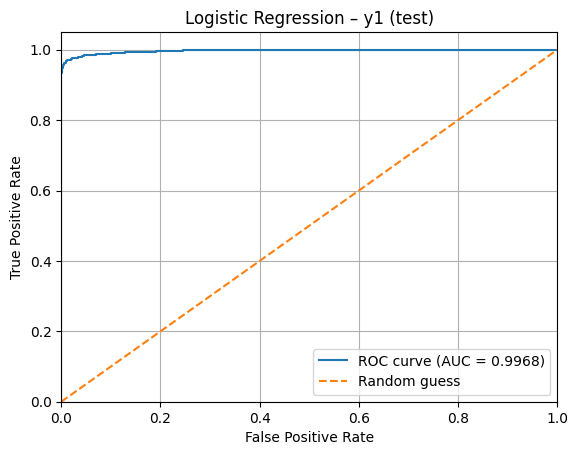

In [38]:
fpr_log_y1, tpr_log_y1, auc_log_y1 = compute_roc_auc(y1_test_log1, log_results1["p_test"])
plot_roc_curve(fpr_log_y1, tpr_log_y1, auc_log_y1,"Logistic Regression – y1 (test)")

This is a NICE curve. Usually we want it to be as L shaped as possible which would translate to having a perfect true possitive rate. In other words, we barely missed any possitive classifications.

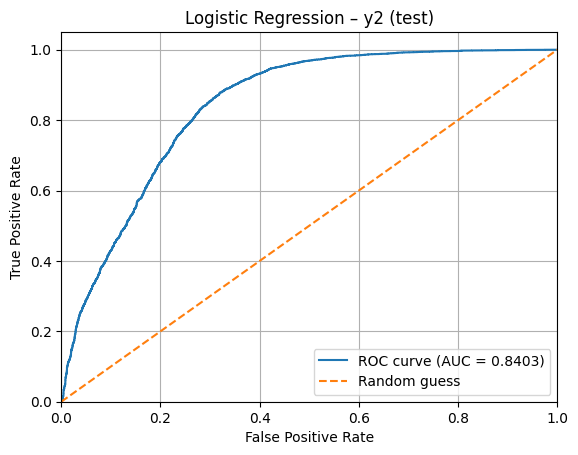

In [39]:
fpr_log_y2, tpr_log_y2, auc_log_y2 = compute_roc_auc(y1_test_log2, log_results2["p_test"])
plot_roc_curve(fpr_log_y2, tpr_log_y2, auc_log_y2,"Logistic Regression – y2 (test)")

Less 'nicer'. 

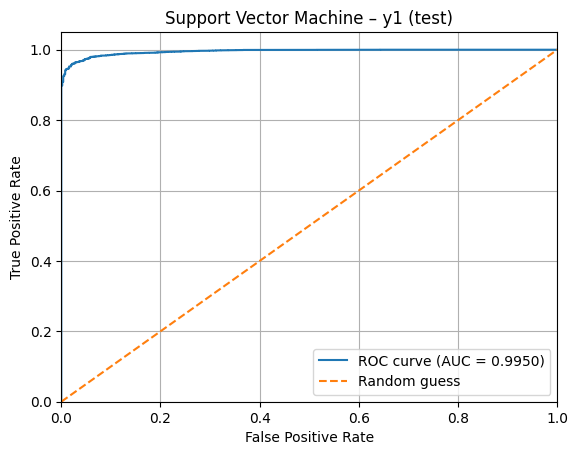

In [40]:
fpr_svm_y1, tpr_svm_y1, auc_svm_y1 = compute_roc_auc(y2_test_svm1, results_svm1["p_test"])
plot_roc_curve(fpr_svm_y1, tpr_svm_y1, auc_svm_y1,"Support Vector Machine – y1 (test)")

Compared to the logarithmic regression model, we may start our assumptions by stating that since we get a slightly 'bigger' area under the curve (which we have yet to discuss). In other words, we have a better *rate* at classifying correct possitives using log model. 

Needless to say, this is also a pretty good classification.

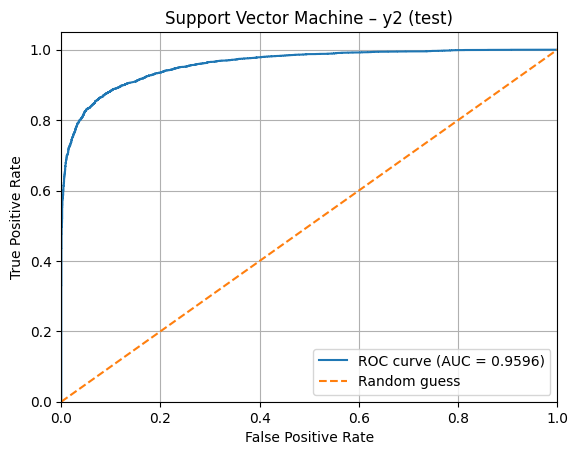

In [41]:
fpr_svm_y2, tpr_svm_y2, auc_svm_y2 = compute_roc_auc(y2_test_svm2, results_svm2["p_test"])
plot_roc_curve(fpr_svm_y2, tpr_svm_y2, auc_svm_y2,"Support Vector Machine – y2 (test)")

Here we actually see the efficience of the svm model. Although for the first probabilistic test the logarithmic regression yields superior metrics, here the svm model clearly comes out on top. As a preliminary result, we might state that if we take both probabilistic approaches into consideration, the svm model performs better on average (taking into account both probs.)

## 3: **Lending Strategies**

In [48]:
## HELPER FUNCTIONS FOR P&L ANALYSIS
def compute_pl_expectation(pl_samples: np.ndarray) -> float:
    """
    Compute the EXPECTED profit & loss (P&L).

    Here, P&L is a random variable:
        - positive values  -> profit
        - negative values  -> loss

    The expectation is simply:
        E[P&L] is approzimately = (1/N) * sum_i pl_i

    Parameters
    ----------
    pl_samples : np.ndarray
        1D array of simulated P&L values.

    Returns
    -------
    expected_pl : float
        Sample mean of the P&L.
    """
    expected_pl = np.mean(pl_samples)
    return expected_pl

def plot_pl_histogram(pl_samples: np.ndarray,
                      title: str = "Histogram of Profit & Loss",
                      bins: int = 50):
    """
    Plot a histogram of simulated P&L values.

    Parameters
    ----------
    pl_samples : np.ndarray
        1D array of simulated P&L values.
    title : str, optional
        Title for the plot.
    bins : int, optional
        Number of bins in the histogram.

    Notes
    -----
    - The vertical axis shows how many simulations fall into each
      P&L interval.
    """
    plt.figure()
    plt.hist(pl_samples, bins=bins, edgecolor="black")
    plt.xlabel("Profit & Loss")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.grid(True)
    plt.show()

def estimate_var_es(pl_samples: np.ndarray,
                    alpha: float = 0.95) -> tuple[float, float]:
    """
    Estimate Value-at-Risk (VaR) and Expected Shortfall (ES)
    at confidence level `alpha` based on simulated P&L.

    Convention used here:
    ---------------------
    - P&L > 0  : profit
    - P&L < 0  : loss

    We define LOSS = -P&L.
      -> large positive LOSS corresponds to large negative P&L.

    For losses L:

        VaR_alpha = quantile_alpha(L)
        ES_alpha  = average of losses that are WORSE than VaR_alpha, i.e.

            ES_alpha = E[L | L >= VaR_alpha]

    Parameters
    ----------
    pl_samples : np.ndarray
        1D array of simulated P&L values.
    alpha : float, optional
        Confidence level (e.g. 0.95 for 95% VaR and ES).

    Returns
    -------
    var_alpha : float
        Estimated VaR at level `alpha` (in loss units).
    es_alpha : float
        Estimated ES at level `alpha` (in loss units).
    """
    # Convert P&L to losses: L = -P&L
    losses = -pl_samples

    # 1) VaR is the alpha-quantile of the loss distribution
    var_alpha = np.quantile(losses, alpha)

    # 2) ES is the average loss in the tail beyond VaR
    tail_losses = losses[losses >= var_alpha]
    es_alpha = tail_losses.mean() if tail_losses.size > 0 else var_alpha

    return var_alpha, es_alpha

def plot_pl_distribution(pl_samples: np.ndarray,
                         title: str = "Empirical CDF of Profit & Loss"):
    """
    Plot the empirical distribution function (CDF) of P&L.

    Steps:
    ------
    1) Sort the P&L samples.
    2) For each sorted value x_(i), define F(x_(i)) = i / N,
       where N is the number of samples.
    3) Plot x_(i) vs F(x_(i)).

    Parameters
    ----------
    pl_samples : np.ndarray
        1D array of simulated P&L values.
    title : str, optional
        Title for the plot.

    Notes
    -----
    - The CDF shows, for any value x, the proportion of scenarios
      with P&L <= x.
    """
    # Sort P&L values
    pl_sorted = np.sort(pl_samples)

    # Empirical CDF values from 1/N to N/N
    n = pl_sorted.size
    cdf = np.arange(1, n + 1) / n

    plt.figure()
    plt.step(pl_sorted, cdf, where="post")
    plt.xlabel("Profit & Loss")
    plt.ylabel("Empirical CDF")
    plt.title(title)
    plt.grid(True)
    plt.show()

def simulate_repayment_scenarios(
    data: pd.DataFrame,
    m: int,
    num_scenarios: int = 50000,
    random_seed: int | None = 123,
) -> np.ndarray:
    """
    Simulate repayment scenarios for the TEST set using the true p2(x).

    We only use the TEST set:
        i = m, ..., m+n-1  

    For each test borrower i and each scenario k, we draw:
        D_{i,k} = 1{ U_{i,k} <= p2(x_i) },
    where U_{i,k} ~ Unif(0,1) are independent.

    Parameters
    ----------
    data : pd.DataFrame
        Full dataset with at least the column "p2_true".
    m : int
        Number of TRAINING observations (first m rows). The rest are TEST.
    num_scenarios : int, optional
        Number of scenarios K to simulate).
    random_seed : int or None, optional
        Seed for reproducibility.

    Returns
    -------
    D : np.ndarray
        2D array of shape (n_test, num_scenarios) with entries in {0,1},
        where n_test = len(data) - m.
        D[i,k] = 1 means borrower i (in test set) repays in scenario k.
    """
    rng = np.random.default_rng(seed=random_seed)

    # Extract true p2(x) for test borrowers
    p2_all = data["p2_true"].to_numpy()   # shape (m + n,)
    p2_test = p2_all[m:]                  # shape (n,)

    n_test = p2_test.size

    # Draw U_{i,k} ~ Unif(0,1) for all i,k
    # Shape: (n_test, num_scenarios)
    U = rng.uniform(low=0.0, high=1.0, size=(n_test, num_scenarios))

    # Repayment indicator: 1 if U <= p2(x), else 0
    D = (U <= p2_test[:, np.newaxis]).astype(int)

    return D

In [51]:
# Simulate repayment scenarios for the test set
D_test = simulate_repayment_scenarios(data, m=m, num_scenarios=50000, random_seed=123)

### **Case (i):** Lend to everyone at 5.5% interest.

In [50]:
def compute_pl_lend_everyone(
    D: np.ndarray,
    loan_amount: float = 1000.0,
    interest_rate: float = 0.055,
) -> np.ndarray:
    """
    Compute scenario P&L for policy (i): lend to EVERY test borrower
    at a fixed interest rate.

    We work scenario by scenario. For each borrower i and scenario k:

        If D_{i,k} = 1 (repayment):
            - We get back principal + interest: loan_amount * (1 + r)
            - We had to put up the principal: loan_amount
            -> Profit on this loan = loan_amount * r

        If D_{i,k} = 0 (default):
            - We lose the principal: - loan_amount
            -> Profit on this loan = - loan_amount

    So, for each loan:
        P&L_{i,k} = loan_amount * [ r * D_{i,k} - 1 * (1 - D_{i,k}) ]

    Total P&L in scenario k = sum over all test borrowers i.

    Parameters
    ----------
    D : np.ndarray
        Repayment indicator matrix of shape (n_test, num_scenarios),
        with entries 0 or 1.
    loan_amount : float, optional
        Principal per loan (CHF). Default: 1000.
    interest_rate : float, optional
        Interest rate 

    Returns
    -------
    pl_scenarios : np.ndarray
        1D array of length num_scenarios, where each entry is the
        TOTAL P&L across all test loans in that scenario.
    """
    r = interest_rate

    # Compute P&L per loan and scenario:
    # shape (n_test, num_scenarios)
    pl_per_loan = loan_amount * (r * D - (1 - D))

    # Sum across loans (axis=0) to get total P&L per scenario
    pl_scenarios = pl_per_loan.sum(axis=0)

    return pl_scenarios

E[P&L] = -3566928.6522
VaR_95 (loss units) = 3609865.0
ES_95  (loss units) = 3620303.582205029


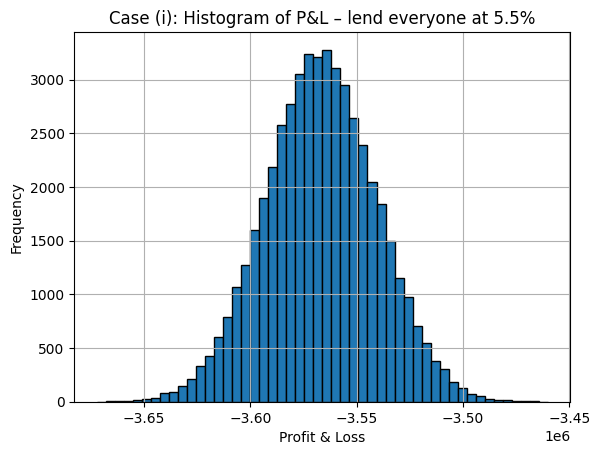

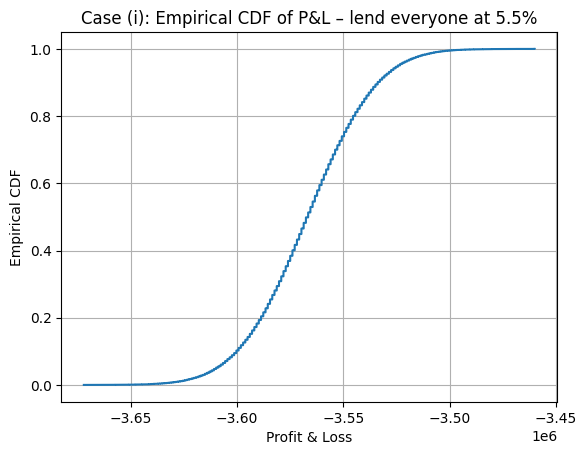

In [ ]:
pl_case_i = compute_pl_lend_everyone(
    D_test,
    loan_amount=1000.0,
    interest_rate=0.055,
)

exp_pl_i = compute_pl_expectation(pl_case_i)
var_95_i, es_95_i = estimate_var_es(pl_case_i, alpha=0.95)

print("E[P&L] =", exp_pl_i)
print("VaR_95 (loss units) =", var_95_i)
print("ES_95  (loss units) =", es_95_i)

plot_pl_histogram(pl_case_i, "Case (i): Histogram of P&L – lend everyone at 5.5%", bins=50)
plot_pl_distribution(pl_case_i, "Case (i): Empirical CDF of P&L – lend everyone at 5.5%")

### **Case (ii):** Lend selectively at 1% interest, but only to applicants with $\hat{p}_2^{\operatorname{log}}(x) \geq 95$%

In [ ]:
def compute_lending_indicator_logistic_y2(
    data: pd.DataFrame,
    m: int,
    log_model_y2,
    feature_cols: list[str] | None = None,
    threshold: float = 0.95,
) -> np.ndarray:
    """
    Compute a 0/1 lending indicator for EACH TEST applicant based on
    the logistic regression model fitted for y2.

    We do:

        1) Extract TEST features X_test (rows m,...,m+n-1).
        2) Compute predicted probabilities:
               p_hat = P(y2 = 1 | x, logistic model).
        3) Define lending rule:
               lend_i = 1 if p_hat_i >= threshold, else 0.

    Parameters
    ----------
    data : pd.DataFrame
        Full dataset with at least the feature columns.
    m : int
        Number of training observations (first m rows). The rest are TEST.
    log_model_y2 :
        Fitted LogisticRegression model for target y2.
        This is the model you obtained earlier with fit_logistic_regression.
    feature_cols : list of str or None, optional
        Names of feature columns. If None, defaults to:
            ["age", "income", "employment"]
    threshold : float, optional
        Lending threshold on predicted probability (default: 0.95).

    Returns
    -------
    lend_indicator : np.ndarray
        1D array of length n_test = len(data) - m, with entries in {0,1}.
        lend_indicator[i] = 1 means "lend to test borrower i".
    """
    if feature_cols is None:
        feature_cols = ["age", "income", "employment"]

    # Extract feature matrix X for all borrowers
    X_all = data[feature_cols].to_numpy()

    # Split into train and test manually (we only need test here)
    X_test = X_all[m:, :]  # rows m,...,m+n-1

    # Predicted probabilities on TEST set:
    # predict_proba returns [:,0] = P(y=0), [:,1] = P(y=1)
    p_hat_test = log_model_y2.predict_proba(X_test)[:, 1]

    # Lending decision: lend if predicted prob >= threshold
    lend_indicator = (p_hat_test >= threshold).astype(int)

    return lend_indicator

def compute_pl_lend_selective(
    D: np.ndarray,
    lend_indicator: np.ndarray,
    loan_amount: float = 1000.0,
    interest_rate: float = 0.01,
) -> np.ndarray:
    """
    Compute scenario P&L for a selective lending policy.

    Inputs:
    -------
    - D: 2D array of shape (n_test, num_scenarios)
         D[i,k] = 1 if test borrower i repays in scenario k
                = 0 if test borrower i defaults in scenario k

    - lend_indicator: 1D array of shape (n_test,)
         lend_indicator[i] = 1 if we decide to lend to borrower i
                           = 0 otherwise

    P&L per loan and scenario:

        If lend_indicator[i] = 1:

            If D[i,k] = 1 (repayment):
                P&L_{i,k} = + loan_amount * interest_rate

            If D[i,k] = 0 (default):
                P&L_{i,k} = - loan_amount

        If lend_indicator[i] = 0:
            P&L_{i,k} = 0

    We compute this vectorized for all i,k.

    Parameters
    ----------
    D : np.ndarray
        Repayment indicator matrix (n_test, num_scenarios), entries 0/1.
    lend_indicator : np.ndarray
        Lending indicator vector (n_test,), entries 0/1.
    loan_amount : float, optional
        Principal per loan, default 1000 CHF.
    interest_rate : float, optional
        Interest rate

    Returns
    -------
    pl_scenarios : np.ndarray
        1D array of length num_scenarios, total P&L per scenario.
    """
    r = interest_rate

    # Compute P&L per loan & scenario as if we lent to everyone:
    # shape (n_test, num_scenarios)
    pl_per_loan_full = loan_amount * (r * D - (1 - D))

    # Apply the lending indicator: if lend_indicator[i] = 0,
    # then the entire row i becomes 0.
    # We do this by multiplying each row i by lend_indicator[i].
    # Expand lend_indicator to shape (n_test, 1) so broadcasting works.
    lend_matrix = lend_indicator[:, np.newaxis]  # shape (n_test, 1)
    pl_per_loan = pl_per_loan_full * lend_matrix

    # Total P&L in each scenario: sum across all test borrowers (axis=0)
    pl_scenarios = pl_per_loan.sum(axis=0)

    return pl_scenarios

Case (ii): E[P&L] = -48405.4798
Case (ii): VaR_95 = 56940.0
Case (ii): ES_95  = 58933.120045300115


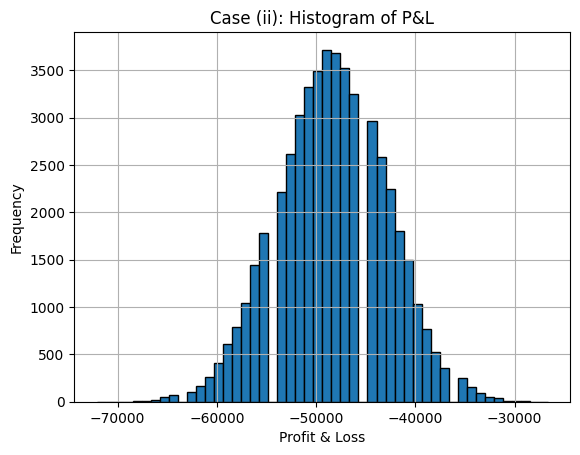

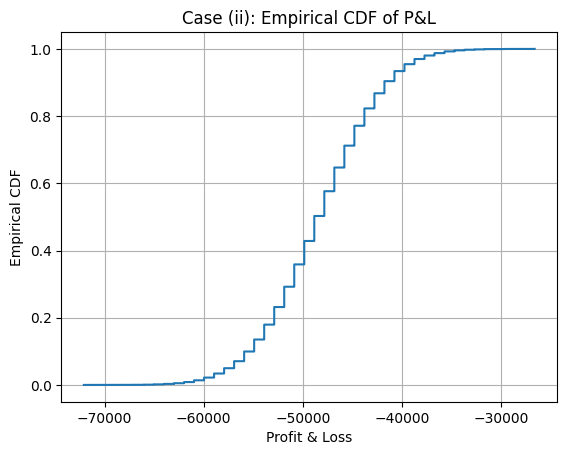

In [35]:
lend_indicator_log2 = compute_lending_indicator_logistic_y2(
    data, m=m, log_model_y2=log_model2, threshold=0.95
)
pl_case_ii = compute_pl_lend_selective(
    D_test,
    lend_indicator=lend_indicator_log2,
    loan_amount=1000.0,
    interest_rate=0.01,
)

exp_pl_ii = compute_pl_expectation(pl_case_ii)
var_95_ii, es_95_ii = estimate_var_es(pl_case_ii, alpha=0.95)

print("Case (ii): E[P&L] =", exp_pl_ii)
print("Case (ii): VaR_95 =", var_95_ii)
print("Case (ii): ES_95  =", es_95_ii)

plot_pl_histogram(pl_case_ii, "Case (ii): Histogram of P&L", bins=50)
plot_pl_distribution(pl_case_ii, "Case (ii): Empirical CDF of P&L")

### **Case (iii):** Same as (ii) but we now focus on aplicants with $\hat{p}_2^{\operatorname{svm}}(x) \geq 95$%

In [ ]:
def compute_lending_indicator_svm_y2(
    data: pd.DataFrame,
    m: int,
    svm_model_y2: SVC,
    scaler_y2: StandardScaler,
    feature_cols: list[str] | None = None,
    threshold: float = 0.95,
) -> np.ndarray:
    """
    Compute a 0/1 lending indicator for EACH TEST applicant based on
    the SVM model fitted for y2.

    Steps:
    ------
    1) Extract feature matrix for all borrowers.
    2) Take the TEST rows (indices m,...,m+n-1).
    3) Standardize them using the SAME scaler used to train the SVM.
    4) Compute predicted probabilities:
           p_hat_svm2(x_i) = P(y2 = 1 | x_i, SVM model)
    5) Lending rule on TEST set:
           lend_i = 1 if p_hat_svm2(x_i) >= threshold, else 0.

    Parameters
    ----------
    data : pd.DataFrame
        Full dataset with at least the feature columns.
    m : int
        Number of TRAINING observations (first m rows). The rest are TEST.
    svm_model_y2 : SVC
        Fitted SVM classifier for target y2 with probability=True.
    scaler_y2 : StandardScaler
        Fitted scaler used to standardize the features for svm_model_y2.
    feature_cols : list of str or None, optional
        Names of feature columns.
        If None, defaults to ["age", "income", "employment"].
    threshold : float, optional
        Lending threshold on predicted probability (default 0.95).

    Returns
    -------
    lend_indicator : np.ndarray
        1D array of length n_test = len(data) - m, with entries in {0,1}.
        lend_indicator[i] = 1 means "lend to test borrower i".
    """
    if feature_cols is None:
        feature_cols = ["age", "income", "employment"]

    # All features
    X_all = data[feature_cols].to_numpy()

    # TEST features: rows m,...,m+n-1
    X_test = X_all[m:, :]

    # Standardize using the SAME scaler as in training
    X_test_std = scaler_y2.transform(X_test)

    # Probabilities on TEST set
    # predict_proba returns [:,0] = P(y=0), [:,1] = P(y=1)
    p_hat_test = svm_model_y2.predict_proba(X_test_std)[:, 1]

    # Lending decision: lend if predicted prob >= threshold
    lend_indicator = (p_hat_test >= threshold).astype(int)

    return lend_indicator

Case (iii) – E[P&L] ≈ -15528.05 CHF


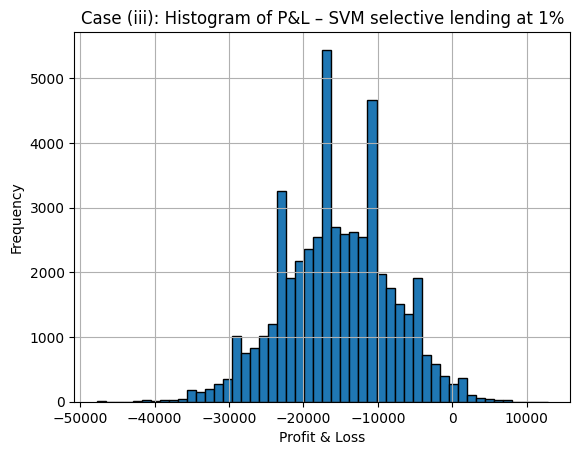

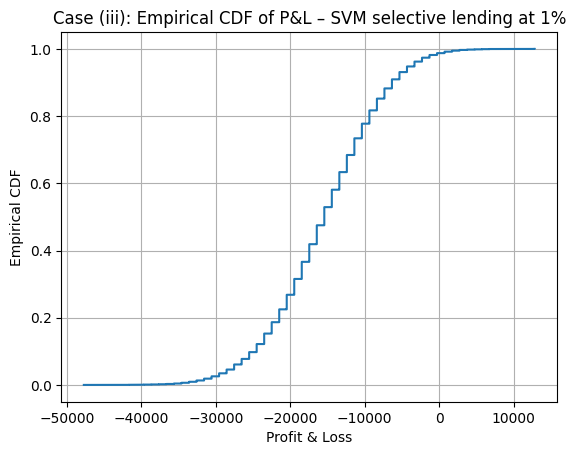

Case (iii) – 95% VaR (loss units): 27550.00 CHF
Case (iii) – 95% ES  (loss units): 30319.20 CHF


In [ ]:
lend_indicator_svm2 = compute_lending_indicator_svm_y2(
    data=data,
    m=m,
    svm_model_y2=svm_model2,       
    scaler_y2=scaler,        # the StandardScaler used for SVM training
    feature_cols=["age", "income", "employment"],
    threshold=0.95,             # lend only if predicted prob >= 95%
)

pl_case_iii = compute_pl_lend_selective(
    D=D_test,
    lend_indicator=lend_indicator_svm2,
    loan_amount=1000.0,
    interest_rate=0.01,         # 1% interest
)

exp_pl_iii = compute_pl_expectation(pl_case_iii)
print(f"Case (iii) – E[P&L] ≈ {exp_pl_iii:.2f} CHF")

plot_pl_histogram(
    pl_case_iii,
    title="Case (iii): Histogram of P&L – SVM selective lending at 1%",
    bins=50,
)

plot_pl_distribution(
    pl_case_iii,
    title="Case (iii): Empirical CDF of P&L – SVM selective lending at 1%",
)

var_95_iii, es_95_iii = estimate_var_es(pl_case_iii, alpha=0.95)
print(f"Case (iii) – 95% VaR (loss units): {var_95_iii:.2f} CHF")
print(f"Case (iii) – 95% ES  (loss units): {es_95_iii:.2f} CHF")